In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from skimage import io, transform

import matplotlib.pyplot as plt # for plotting
import numpy as np
import pandas as pd
import glob
import os

#import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

#from tqdm import tqdm

In [25]:
# DataLoader Class
# if BATCH_SIZE = N, dataloader returns images tensor of size [N, C, H, W] and labels [N]
class ImageDataset(Dataset):
    
    def __init__(self, data_csv, train = True , img_transform=None):
        """
        Dataset init function
        
        INPUT:
        data_csv: Path to csv file containing [data, labels]
        train: 
            True: if the csv file has [labels,data] (Train data and Public Test Data) 
            False: if the csv file has only [data] and labels are not present.
        img_transform: List of preprocessing operations need to performed on image. 
        """
        
        self.data_csv = data_csv
        self.img_transform = img_transform
        self.is_train = train
        
        data = pd.read_csv(data_csv, header=None)
        if self.is_train:
            images = data.iloc[:,1:].to_numpy()
            labels = data.iloc[:,0].astype(int)
        else:
            images = data.iloc[:,:]
            labels = None
        
        self.images = images
        self.labels = labels
        print("Total Images: {}, Data Shape = {}".format(len(self.images), images.shape))
        
    def __len__(self):
        """Returns total number of samples in the dataset"""
        return len(self.images)
    
    def __getitem__(self, idx):
        """
        Loads image of the given index and performs preprocessing.
        
        INPUT: 
        idx: index of the image to be loaded.
        
        OUTPUT:
        sample: dictionary with keys images (Tensor of shape [1,C,H,W]) and labels (Tensor of labels [1]).
        """
        image = self.images[idx]
        image = np.array(image).astype(np.uint8).reshape((32, 32, 3),order='F')
        ,
        if self.is_train:
            label = self.labels[idx]
        else:
            label = -1
        
        image = self.img_transform(image)
        
        sample = {"images": image, "labels": label}
        return sample

In [26]:
# Data Loader Usage

BATCH_SIZE = 200 # Batch Size. Adjust accordingly
NUM_WORKERS = 20 # Number of threads to be used for image loading. Adjust accordingly.

img_transforms = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])

# Train DataLoader
train_data = "../CIFAR/train_data.csv" # Path to train csv file
train_dataset = ImageDataset(data_csv = train_data, train=True, img_transform=img_transforms)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

# Test DataLoader
test_data = "../CIFAR/public_test.csv" # Path to test csv file
test_dataset = ImageDataset(data_csv = test_data, train=True, img_transform=img_transforms)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

Total Images: 60000, Data Shape = (60000, 3072)
Total Images: 4000, Data Shape = (4000, 3072)


In [27]:
torch.cuda.is_available()

True

In [28]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = Sequential(
            Conv2d(3, 32, kernel_size=3, stride=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv2 = Sequential(
            Conv2d(32, 64, kernel_size=3, stride=1),
            BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv3 = Sequential(
            Conv2d(64, 512, kernel_size=3, stride=1),
            BatchNorm2d(512),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv4 = Sequential(
            Conv2d(512, 1024, kernel_size=2, stride=1),
            ReLU(inplace=True),
        )

        self.linear1 = Sequential(
            Linear(1024 * 1 * 1, 256),
            ReLU(inplace=True),
        )
        self.drop = Dropout(p=0.2)
        self.linear2 = Linear(256,10)
        

    # Defining the forward pass    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(x.size(0), -1)

        x = self.linear1(x)
        x = self.drop(x)
        x = self.linear2(x)
        
        return x

In [29]:
def train_model(epoch,x_train,y_train):
    model.train()
    tr_loss = 0
    x_train, y_train = Variable(x_train), Variable(y_train)
  
    if torch.cuda.is_available():     # converting the data into GPU format
        x_train = x_train.cuda()
        y_train = y_train.cuda()
    
    optimizer.zero_grad()             # clearing the Gradients of the model parameters
    
    # prediction for training and validation set
    output_train = model(x_train)
    
    # computing the training and validation loss
    loss_train = loss(output_train, y_train)
    #print(loss_train)
  
    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()

    return tr_loss

def predict_model(x_test,y_test):
   
    if torch.cuda.is_available():     # converting the data into GPU format
        x_test = x_test.cuda()

    with torch.no_grad():
      output = model(x_test)
    
    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)

    #pred = np.append(pred,predictions)

    #print(predictions,y_test.cpu().detach().numpy())
    
    return (np.sum(predictions==y_test.cpu().detach().numpy()))


In [30]:
model = Net()

optimizer = Adam(model.parameters(), lr=0.0001)
loss = CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    loss = loss.cuda()

In [31]:
epochs = 5
torch.autograd.set_detect_anomaly(True)
loss_file = open('loss.txt','w')
acc_file = open('accuracy.txt','w')

losses = []
accs = []



for epoch in range(epochs):
    avg_train_loss = 0
    acc = 0
    n = 0
    
    model.train()
    for batch_idx, sample in enumerate(train_loader):
      images = sample['images']
      labels = sample['labels']
      avg_train_loss += train_model(epoch,images,labels)

    model.eval()
    for b,sample in enumerate(test_loader):
      images = sample['images']
      labels = sample['labels']
      n += len(labels)
      acc += predict_model(images,labels)


    avg_train_loss /= len(train_loader)
    acc /= n
    loss_file.write('{}\n'.format(avg_train_loss))
    losses.append(avg_train_loss)
    acc_file.write('{}\n'.format(acc))
    accs.append(acc)

    print(epoch+1,avg_train_loss,acc)

loss_file.close()
acc_file.close()

1 1.4349405539035798 0.6045
2 1.060920416911443 0.65475
3 0.902414954106013 0.68575
4 0.778508681456248 0.698
5 0.6676647782325744 0.699


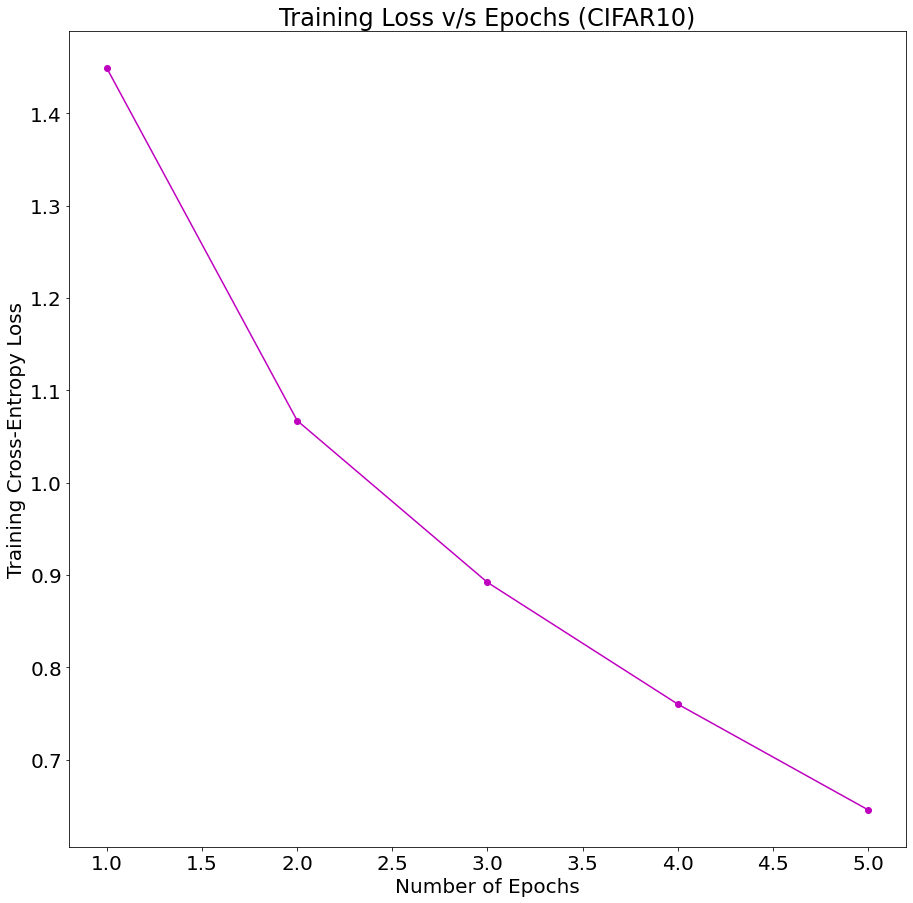

In [5]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (15,15)

x = [1,2,3,4,5]
y= [
1.4485580623149872,
1.0671111538012823,
0.8919388349850973,
0.7601574355363846,
0.6457052547732989,
]

plt.xlabel("Number of Epochs")
plt.ylabel("Training Cross-Entropy Loss")
plt.title('Training Loss v/s Epochs (CIFAR10)')

plt.plot(x,y,'-mo')
plt.savefig('c10plt.png')


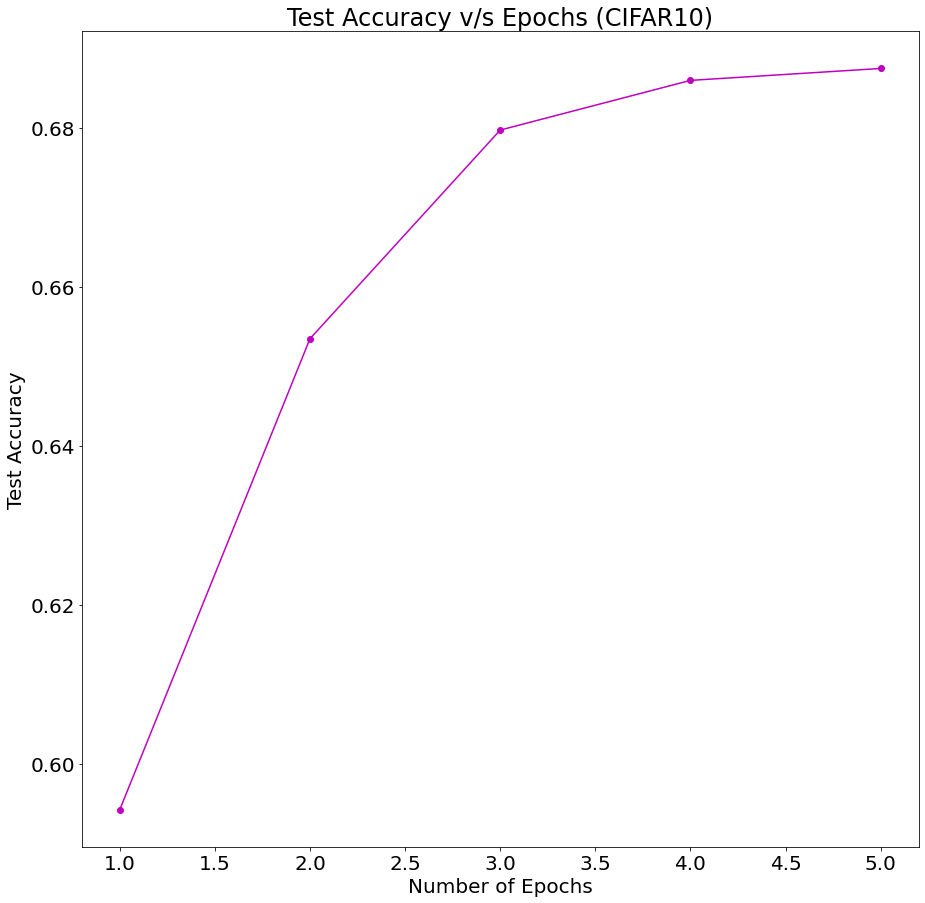

In [6]:
y = [0.59425,
0.6535,
0.67975,
0.686,
0.6875,
]

plt.xlabel("Number of Epochs")
plt.ylabel("Test Accuracy")
plt.title('Test Accuracy v/s Epochs (CIFAR10)')


plt.plot(x,y,'-mo')
plt.savefig('c10plt1.png')

In [34]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.0.weight 	 torch.Size([32, 3, 3, 3])
conv1.0.bias 	 torch.Size([32])
conv1.1.weight 	 torch.Size([32])
conv1.1.bias 	 torch.Size([32])
conv1.1.running_mean 	 torch.Size([32])
conv1.1.running_var 	 torch.Size([32])
conv1.1.num_batches_tracked 	 torch.Size([])
conv2.0.weight 	 torch.Size([64, 32, 3, 3])
conv2.0.bias 	 torch.Size([64])
conv2.1.weight 	 torch.Size([64])
conv2.1.bias 	 torch.Size([64])
conv2.1.running_mean 	 torch.Size([64])
conv2.1.running_var 	 torch.Size([64])
conv2.1.num_batches_tracked 	 torch.Size([])
conv3.0.weight 	 torch.Size([512, 64, 3, 3])
conv3.0.bias 	 torch.Size([512])
conv3.1.weight 	 torch.Size([512])
conv3.1.bias 	 torch.Size([512])
conv3.1.running_mean 	 torch.Size([512])
conv3.1.running_var 	 torch.Size([512])
conv3.1.num_batches_tracked 	 torch.Size([])
conv4.0.weight 	 torch.Size([1024, 512, 2, 2])
conv4.0.bias 	 torch.Size([1024])
linear1.0.weight 	 torch.Size([256, 1024])
linear1.0.bias 	 torch.Size([256])
linear2.weight 	 t

In [35]:
torch.save(model.state_dict(),'./model2.pth')